# Homework 2

In this homework, you will be implementing Deep Q Networks and Asynchronous Advantage Actor-Critic models and use them in two of the Atari games and simple gym environments. You will need to fill the missing parts in the modules and then run your tests in the notebook.

## 1) Deep Q Networks (50)

As seen in the class, DQN has two main features, namely target networks and replay buffer. However, additional improvements have been introduced since the first release of DQN.

- [Prioritized Replay Buffer](https://arxiv.org/pdf/1509.06461.pdf)
- [Double Deep Q Networks](https://arxiv.org/pdf/1511.05952.pdf)
- [Dueling Deep Q Networks](https://arxiv.org/pdf/1511.06581.pdf)

After implementing these methods, you can compare combined algorithm with the vanilla DQN. For comparison you will be using two [gym](https://gym.openai.com/) environments. 
- [Lunar Lander](LunarLander-v2)
- [Pong](https://gym.openai.com/envs/Pong-v0/)



In [ ]:
# In order to use modified modules without restarting
%load_ext autoreload
%autoreload 2

In [ ]:
import torch; 
from gym.version import VERSION
print(torch.__version__)
print(VERSION)
%load_ext line_profiler

In [ ]:
import gym
import numpy as np
import torch

from blg604ehw2.dqn import episodic_test
from blg604ehw2.dqn import episodic_train

from blg604ehw2.network import Network
from blg604ehw2.network import FcNet
from blg604ehw2.network import DuelingHead
from blg604ehw2.network import SimpleHead

from blg604ehw2.utils import comparison
from blg604ehw2.utils import LoadingBar

### Lunar Lander with DQN (15)

In [ ]:
def traindqn(env, agent, args, test_rate=1):
    bar = LoadingBar(args.episode, "Episode")
    #agent.to(args.device)
    agent.device = args.device
    epsilons = np.linspace(args.max_epsilon , args.min_epsilon, num=args.episode)
    time_step = 0
    rewards = []
    td_errors = []

    best_model = None
    best_rewards = []
    best_reward = -np.inf
    #import pdb;pdb.set_trace()
    for eps in range(args.episode):
        ### YOUR CODE HERE ###
        time_step, td_error = episodic_train(env, agent, args, epsilons[eps])
        if eps % test_rate == 0:
            reward = 0
            for it in range(test_rate):
                reward += episodic_test(env, agent, args)
            reward /= test_rate
            best_reward = reward if best_reward < reward else best_reward
        best_rewards.append(best_reward)
        td_errors.append(td_error)
        rewards.append(reward)
        best_model = agent if best_reward == reward else best_model
        
        ###       END      ###
        bar.progress(eps, best_reward)
        
    bar.success(best_reward)
    return rewards, best_rewards, td_errors, time_step, best_model

### a) Vanilla DQN

In [ ]:
from blg604ehw2.dqn import DQN
from blg604ehw2.dqn import ArgsDQN

# Set the environment name, you can try differnet environments.
envname = "LunarLander-v2"

# Hyperparameters for the traning
# You need to finetune some of the  hyperparameters!
env = gym.make(envname)
dqn_args = ArgsDQN(
        **dict(
            env_name=envname,           # Name of the environment
            nstates=env.observation_space.shape,  
            nact=env.action_space.n,    # Number of actions
            buffersize=20000,           # Size of the replay buffer
            max_epsilon=0.9,            # Starting value of the epsilon
            min_epsilon=0.1,            # Convergence value of the epsilon
            target_update_period=50,    # Update period of the target network
            gamma=0.99,                 # Discount rate
            lr=0.001,                   # Learning rate
            device="cuda",              # Device name
            batch_size=128,             # Batch size
            episode=10,             # Number of episodes for training
            max_eps_len=600          # Maximum number of time steps in an episode
        )
    )

def dqn_agent():
    # Network construction
    feature_net = FcNet(env.observation_space.shape[0], 128)
    head_net = SimpleHead(env.action_space.n, 128)
    valuenet = Network(feature_net, head_net)
    
    # Initialize and return agent
    return DQN(
        dev = dqn_args.device,
        valuenet = valuenet,
        nact = env.action_space.n,
        lr = dqn_args.lr,
        buffer_capacity = dqn_args.buffersize,
        target_update_period = dqn_args.target_update_period
        )

In [ ]:
REPEAT = 1
lunar_dqn = []
#with torch.autograd.profiler.profile(use_cuda=True) as prof:
for r in range(REPEAT):
    env = gym.make(dqn_args.env_name)
    agent = dqn_agent()
    lunar_dqn.append(traindqn(env, agent, dqn_args, test_rate=5))

In [ ]:
prof.table(sort_by="cuda_time_total")
prof.key_averages()
prof.export_chrome_trace("/home/cbekar/Desktop/trace")

In [ ]:
    plot_texts = [
    [
        "Episodic Reward",
        "episode",
        "reward"
    ],
    [
        "Episodic Best Reward",
        "episode",
        "reward"
    ],
    [
        "Td Error",
        "episode",
        "td"
    ]
]

In [ ]:
comparison((lunar_dqn, "DQN"), texts = plot_texts)

In [ ]:
# Remember that due to the stochasticty of the
# environment it may perform differently for each run

# Assuming ddpdqn works better in your environment as it should be
#import pdb;pdb.set_trace()
best_agent_index = max(range(len(lunar_dqn)), key = lambda i: lunar_dqn[i][1][-1])
best_agent_state_dict = lunar_dqn[best_agent_index][4]
best_agent = dqn_agent()
########!best_agent.load_state_dict(best_agent_state_dict)

# Monitor saves the mp4 files under "monitor" folder.
monitor_path = "LunarLander/DQN/" + str(dqn_args.episode) + " episode"
model_path = "monitor/LunarLander/model_state_dict"
episodic_test(agent=lunar_dqn[best_agent_index][4], env=gym.make(dqn_args.env_name), args=dqn_args, monitor_path=monitor_path)
torch.save(best_agent_state_dict, model_path)

In [ ]:
monitor_path = "LunarLander/DQN/" + str(dqn_args.episode) + " episode"
model_path = "model_state_dict"
best_agent = torch.load(model_path)
episodic_test(agent=best_agent, env=gym.make(dqn_args.env_name), args=dqn_args, monitor_path=monitor_path)

In [ ]:
env.close()

### b) Dueling Double Prioritized DQN (15)

In [ ]:
from blg604ehw2.dqn import DuelingDoublePrioritizedDQN
from blg604ehw2.dqn import ArgsDDPQN


# Hyperparameters for the traning
# You need to finetune some of the  hyperparameters!
envname = "LunarLander-v2"
env = gym.make(envname)
ddpdqn_args = ArgsDDPQN(
        **dict(
            env_name=envname,           # Name of the environment
            nstates=env.observation_space.shape,
            nact=env.action_space.n,    # Number of actions
            buffersize=20000,           # Size of the replay buffer
            max_epsilon=0.9,            # Starting value of the epsilon
            min_epsilon=0.1,            # Convergence value of the epsilon
            target_replace_period=50,   # Update period of the target network
            gamma=0.99,                 # Discount rate
            lr=0.001,                   # Learning rate
            device="cuda",               # Device name
            batch_size=128,             # Batch size
            episode=10,                 # Number of episodes for training
            max_eps_len=400             # Maximum number of time steps in an episode
        )
    )

def ddpdqn_agent():
    # Network construction
    feature_net = FcNet(env.observation_space.shape[0], 128)
    head_net = DuelingHead(env.action_space.n, 128)
    valuenet = Network(feature_net, head_net)

    # Initialize agent
    return DuelingDoublePrioritizedDQN(
        dev = ddpdqn_args.device,
        valuenet = valuenet,
        nact = env.action_space.n,
        lr = ddpdqn_args.lr,
        buffer_capacity = ddpdqn_args.buffersize,
        target_replace_period = ddpdqn_args.target_replace_period,
        gamma = ddpdqn_args.gamma
    )

In [ ]:
REPEAT = 1
lunar_ddpdqn = []
for r in range(REPEAT):
    env = gym.make(ddpdqn_args.env_name)
    agent = ddpdqn_agent()
    lunar_ddpdqn.append(traindqn(env, agent, ddpdqn_args, test_rate=5))

In [ ]:
comparison((lunar_ddpdqn, "DDPDQN"), (lunar_dqn, "DQN"), texts = plot_texts)

You may compare these improvements by themselves if you want to. See which one of them makes the most improvement for the Lunar Lander environment.(optional)

#### Let's visualize the best agent

In [ ]:
# Remember that due to the stochasticty of the
# environment it may perform differently for each run

# Assuming ddpdqn works better in your environment as it should be
best_agent_index = max(range(len(lunar_ddpdqn)), key = lambda i: lunar_ddpdqn[i][1][-1])
best_agent_state_dict = lunar_ddpdqn[best_agent_index][4]
best_agent = ddpdqn_agent()
best_agent.load_state_dict(best_agent_state_dict)

# Monitor saves the mp4 files under "monitor" folder.
monitor_path = "LunarLander/" + str(ddpdqn_args.episode) + " episode"
model_path = "monitor/LunarLander/model_state_dict"
episodic_test(agent=best_agent, env=gym.make(ddpdqn_args.env_name), args=ddpdqn_args, monitor_path=monitor_path)
torch.save(best_agent_state_dict, model_path)

### Pong with Dueling Double Prioritized DQN (20)
- This may take long time

In [ ]:
from blg604ehw2.atari_wrapper import ClipRewardEnv
from blg604ehw2.atari_wrapper import FrameStack
from blg604ehw2.atari_wrapper import EpisodicLifeEnv
from blg604ehw2.atari_wrapper import WarpFrame
from blg604ehw2.atari_wrapper import ScaledFloatFrame

from blg604ehw2.network import Cnn

envname = "PongNoFrameskip-v4" # Should be without frameskips

# Wrapped atari environment.
# It is important to use these wrappers in order
# to simplfy learning. In their Nature paper,
# Deepmind used some of them to achive those
# results. It is good to check them and see 
# what do they do.
def pongenv():
    env = gym.make(envname)
    env = ClipRewardEnv(env)            # Clip the reward between -1 and 1
    env = WarpFrame(env)                # Downsample rgb (210, 160, 3) images to gray images (84, 84)
    env = EpisodicLifeEnv(env)          # Terminate the environment after a live is lost
    env = FrameStack(env, k=4)          # Stack consecutive frames as a single state
    return env

# Hyperparameters for the traning
# This time parameter tunning is even more important!
# If you have access to a gpu use it! Set the device accordingly.
env = pongenv()
pong_args = ArgsDDPQN(
        **dict(
            env_name=envname,           # Name of the environment
            nstates=env.observation_space,
            nact=env.action_space.n,    # Number of actions
            buffersize=1000,          # Size of the replay buffer
            max_epsilon=0.9,            # Starting value of the epsilon
            min_epsilon=0.1,            # Convergence value of the epsilon
            target_replace_period=100,  # Update period of the target network
            gamma=0.97,                 # Discount rate
            lr=0.0002,                  # Learning rate
            device="cuda",              # Device name
            batch_size=128,             # Batch size
            episode=10,               # Number of episodes for training
            max_eps_len=100            # Maximum number of time steps in an episode
        )
    )

def pong_agent():
    # Network construction
    feature_net = Cnn(4, 512)
    head_net = DuelingHead(env.action_space.n, 512)
    valuenet = Network(feature_net, head_net)

    # Initialize agent
    return DuelingDoublePrioritizedDQN(
        dev = pong_args.device,
        valuenet = valuenet,
        nact = env.action_space.n,
        lr = pong_args.lr,
        buffer_capacity = pong_args.buffersize,
        target_replace_period = pong_args.target_replace_period
    )

In [ ]:
REPEAT = 1 # Assign 1 if you dont want to train more than one
pong_ddpdqn = []
for r in range(REPEAT):
    env = pongenv()
    agent = pong_agent()
    pong_ddpdqn.append(traindqn(env, agent, pong_args, test_rate=3))

In [ ]:
comparison((pong_ddpdqn, "PONG"), texts = plot_texts)

In [ ]:
best_agent_index = max(range(len(pong_ddpdqn)), key = lambda i: pong_ddpdqn[i][1][-1])
best_agent_state_dict = pong_ddpdqn[best_agent_index][4]
best_agent = pong_agent() 
#best_agent.load_state_dict(best_agent_state_dict)

# Monitor saves the mp4 files under "monitor" folder.
monitor_path = "Pong/" + str(pong_args.episode) + " episode"
model_path = "monitor/Pong/model_state_dict"
episodic_test(agent=pong_ddpdqn[best_agent_index][4], env=pongenv(), args=pong_args, monitor_path=monitor_path)
torch.save(best_agent_state_dict, model_path)

## 2) Asynchronous Advantage Actor-Critic (50)
[A3C](https://arxiv.org/abs/1602.01783) is a policy gradinet algorithm which is based on asynchronous updates of paralel agents.
You will be testing your agent in:

- [Bipedal Walker](https://gym.openai.com/envs/BipedalWalker-v2/)
- [Breakout](https://gym.openai.com/envs/Breakout-v0/)

### a) Bipedal Walker with Asynchronous Advantage Actor-Critic (20)
It is important to test your implementation with a simpler enviroment like BipedalWalker before trying Breakout.
It is highly recommended to check the pseudocode in the paper's appendix.

The implementation works as follows:

    - Create a global agent which's paremeters are in the shared memory.
    - Create multiple worker processes. That performs:
        - Gradient calculation with the transition it observed
        - Update the global agent with the gradients
        - Synchronize with the global agent
    - Create a test process that evaluates the performance of the global agent over the course of the training
    - Run these workers asynchronously
    
   

In [ ]:
# In order to use modified modules without restarting
%load_ext autoreload
%autoreload 2

In [ ]:
import gym
from collections import namedtuple
import torch.multiprocessing as mp 

from blg604ehw2.network import FcNet
from blg604ehw2.network import ContinuousDistHead
from blg604ehw2.network import Network

from blg604ehw2.a3c import ContinuousA3c
from blg604ehw2.a3c import SharedAdam
from blg604ehw2.a3c import train_worker
from blg604ehw2.a3c import test_worker
from blg604ehw2.a3c import A3C_args


# Bipedal Walker environment is similar to Lunar Lander
# State space is a vector of length 24 and there are
# 4 actions
envname = "BipedalWalker-v2"

# Logger is a named tuple of shared lists integer and a model
# It is necessary to have a shared object since it can be used
# by many processes
Logger = namedtuple("Logger", "eps_reward best_reward best_model time_steps time")

# Hyperparameters, again tunning is necessary but optional.
a3c_args = A3C_args(
    **dict(
        maxtimestep=100000,     # Number of time steps for training
        maxlen=600,             # Maximum length of an episode
        nstep=20,               # Bootsrapping length (n-step td)
        gamma=0.98,             # Discount rate
        lr=0.0001,              # Learning rate
        beta=0.01,              # Entropy regularization constant
        device="cpu",           # Device
    )
)

# Agent generating function
def a3c_agent():
    feature_net = FcNet(24)
    head_net = ContinuousDistHead(128, 4)
    network = Network(feature_net, head_net)
    agent = ContinuousA3c(network)
    agent.device = a3c_args.device
    return agent

# Environment generating function
# You can use RewardClip wrapper
def walker_env():
    env =  gym.make(envname)
    return env
    

In [ ]:
### Main cell for Bipedal Walker ###

# Number of training workers
N_PROCESSES = mp.cpu_count()

# Global agent that will be used for synchronization.
global_agent = a3c_agent()
global_agent.share_memory()         # Make sure it is in the shared memory!

# Shared optimizer, since the optimizer has its own parameters
# they need to be in the shared memory as well.
sharedopt = SharedAdam(global_agent.parameters(), lr=a3c_args.lr)

# Another agent for logging purposes
best_agent = a3c_agent()
best_agent.share_memory()

# Logger
# Manager controls another process(server process) to share
# objects between multiple processes via proxies.
# Please read https://docs.python.org/3.7/library/multiprocessing.html
# for more information.
manager = mp.Manager()
logger = Logger(
    manager.list(),
    manager.list(),
    best_agent,
    manager.list(),
    manager.Value("i", 0)
)
logger.time_steps.append(0)
for t in range(a3c_args.maxtimestep):
    logger.eps_reward.append(None)
    logger.best_reward.append(None)
    
# Lock is not necessary
lock = mp.Lock()

# Start by creating a test worker
processes = []
process = mp.Process(target=test_worker,
                     args=(a3c_args, global_agent, walker_env, a3c_agent, lock, logger,\
                           None,False))
# test_worker(a3c_args, global_agent, walker_env, a3c_agent, N_PROCESSES, logger)
# train_worker(a3c_args, global_agent, sharedopt, walker_env, a3c_agent, 0, N_PROCESSES, logger)
process.start()
processes.append(process)

# # Train workers
for t in range(N_PROCESSES):
    process = mp.Process(target=train_worker,
                         args=(a3c_args, global_agent, sharedopt, walker_env, a3c_agent, t, N_PROCESSES, logger))
    process.start()
    processes.append(process)
    
# Wait until all done
for p in processes:
    p.join()

In [ ]:
# Plot the rewards from the logger
import matplotlib.pyplot as plt
plt.title("A3C Walker Best Rewards")
plt.ylabel("reward")
plt.xlabel("time steps")
plt.plot(list(logger.time_steps), list(logger.best_reward))

### b) Breakout with Asynchronous Advantage Actor-Critic (30)

- It takes a lot of time so be prepared.

In [1]:
# In order to use modified modules without restarting
%load_ext autoreload
%autoreload 2

In [2]:
import gym
from blg604ehw2.atari_wrapper import ClipRewardEnv
from blg604ehw2.atari_wrapper import FrameStack
from blg604ehw2.atari_wrapper import EpisodicLifeEnv
from blg604ehw2.atari_wrapper import WarpFrame
from blg604ehw2.atari_wrapper import ScaledFloatFrame

from blg604ehw2.network import Cnn
from blg604ehw2.network import DiscreteDistHead
from collections import namedtuple
import torch.multiprocessing as mp 
from blg604ehw2.a3c import DiscreteA3c
from blg604ehw2.a3c import A3C_args
from blg604ehw2.network import Network
from blg604ehw2.a3c import SharedAdam
from blg604ehw2.a3c import train_worker
from blg604ehw2.a3c import test_worker
# Breakout Environment
envname = "Breakout-v4"
Logger = namedtuple("Logger", "eps_reward best_reward best_model time_steps time")

# Hyperparameters
breakout_args = A3C_args(
    **dict(
        maxtimestep=40000000,
        maxlen=2000,
        nstep=20,
        gamma=0.98,
        lr=0.00003,
        beta=0.01,
        device="cpu",
    )
)

def breakout_agent():
    feature_net = Cnn(4, 512) # 4 channel size because of the StackFrame buffer
    head_net = DiscreteDistHead(512, 4) # 4 output because of the environment's action space
    network = Network(feature_net, head_net)
    agent = DiscreteA3c(network)
    agent.device = breakout_args.device
    return agent

def breakout_env():
    env = gym.make(envname)
    env = ClipRewardEnv(env)            # Clip the reward between -1 and 1
    env = WarpFrame(env)                # Downsample rgb (210, 160, 3) images to gray images (84, 84)
    env = EpisodicLifeEnv(env)          # Terminate the environment after a live is lost
    env = FrameStack(env, k=4)          # Stack consecutive frames as a single state
    return env


In [ ]:
### Main cell for Breakout ###

N_PROCESSES = mp.cpu_count()

global_agent = breakout_agent()
global_agent.share_memory()
sharedopt = SharedAdam(global_agent.parameters(), lr=breakout_args.lr)

best_agent = breakout_agent()
best_agent.share_memory()

# Try to use one manager
manager = mp.Manager()
logger = Logger(
    manager.list(),
    manager.list(),
    best_agent,
    manager.list(),
    manager.Value("i", 0)
)
logger.time_steps.append(0)
import pdb;pdb.set_trace()
for t in range(N_PROCESSES):
    logger.eps_reward.append(None)
    logger.best_reward.append(None)
lock = mp.Lock()

processes = []

process = mp.Process(target=test_worker,
                     args=(breakout_args, global_agent, breakout_env, breakout_agent, lock, logger))
#train_worker(breakout_args, global_agent, sharedopt, breakout_env, breakout_agent, 0, N_PROCESSES, logger)
# test_worker(breakout_args, global_agent, breakout_env, breakout_agent, N_PROCESSES, logger)
process.start()
processes.append(process)
for t in range(N_PROCESSES):
    process = mp.Process(target=train_worker,
                         args=(breakout_args, global_agent, sharedopt, breakout_env, breakout_agent, t, N_PROCESSES, logger))
    process.start()
    processes.append(process)
for p in processes:
    p.join()

--Return--
> <ipython-input-5-49592461b48a>(22)<module>()->None
-> import pdb;pdb.set_trace()
(Pdb) n
> /home/cbekar/miniconda3/envs/blg604ehw2/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3299)run_code()
-> sys.excepthook = old_excepthook
(Pdb) b 25
Breakpoint 1 at /home/cbekar/miniconda3/envs/blg604ehw2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:25
(Pdb) c


/home/cbekar/miniconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/cbekar/miniconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/cbekar/miniconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/cbekar/miniconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/cbekar/miniconda3/envs/blg604ehw2/lib/


Program interrupted. (Use 'cont' to resume).
--Call--
> /home/cbekar/miniconda3/envs/blg604ehw2/lib/python3.7/bdb.py(319)set_trace()
-> def set_trace(self, frame=None):

Program interrupted. (Use 'cont' to resume).
--Call--
> /home/cbekar/miniconda3/envs/blg604ehw2/lib/python3.7/bdb.py(319)set_trace()
-> def set_trace(self, frame=None):


ValueError: x and y must have same first dimension, but have shapes (1,) and (8,)

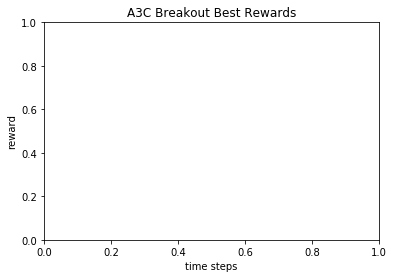

In [4]:
# Plot the rewards from the logger
import matplotlib.pyplot as plt
plt.title("A3C Breakout Best Rewards")
plt.ylabel("reward")
plt.xlabel("time steps")
plt.plot(list(logger.time_steps), list(logger.best_reward))

In [ ]:
# Save the best model's parameters
model_path = "monitor/Breakout/model_state_dict"
torch.save(logger.best_model.state_dict(), model_path)